<a href="https://colab.research.google.com/github/toledotorrespatricio/hjb-nn-mmcc/blob/main/sls_20250813.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# ============================================================================
# VERSIÓN MEJORADA: Con normalización de costos según la imagen
# ============================================================================
import os, datetime, numpy as np, tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Configuración GPU
gpus = tf.config.list_physical_devices('GPU')
for g in gpus:
    tf.config.experimental.set_memory_growth(g, True)

DEVICE = '/GPU:0' if gpus else '/CPU:0'
print("🔧  Usando dispositivo:", DEVICE)

# TensorBoard
log_dir = "logs/slscheme_improved/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = tf.summary.create_file_writer(log_dir)

with tf.device(DEVICE):
    # -----------------------------------------------------------------------
    # 1) PARÁMETROS DEL SISTEMA
    # -----------------------------------------------------------------------
    C1, C2, C3 = 1_000.0, 5_000.0, 1e-3

    A_mat = tf.constant([[1., 0., .5],
                         [0., 1., .5]], dtype=tf.float32)
    A_pinv = tf.linalg.pinv(A_mat)

    K_mat = tf.constant([[ 2/3, -1/3, -1/3],
                         [-1/3,  2/3, -1/3],
                         [-1/3, -1/3,  2/3]], dtype=tf.float32)

    state_dim, control_dim = 7, 3
    x_min, x_max = 0., 1_000.
    y_min, y_max = -15., 15.
    u_min, u_max = -1., 1.
    λ_w, λ_x, λ_z, λ_u = 0.8, 0.15, 0.025, 0.025
    w_ref_0 = np.array([15.0, 5.0])  # w_ref en t=0
    A_np = np.array([[1., 0., 0.5], [0., 1., 0.5]])
    y_inicial = np.linalg.pinv(A_np) @ w_ref_0


    # -----------------------------------------------------------------------
    # PARÁMETROS DE NORMALIZACIÓN DE COSTOS
    # -----------------------------------------------------------------------
    # Límites esperados para cada error (basados en el sistema)
    # Error w: Ay - w_ref
    e_w_min = tf.constant([-20., -10.], dtype=tf.float32)  # Min esperado
    e_w_max = tf.constant([20., 10.], dtype=tf.float32)    # Max esperado

    # Error x: x - x_ref
    e_x_min = tf.constant([-880., -880., -880.], dtype=tf.float32)
    e_x_max = tf.constant([120., 120., 120.], dtype=tf.float32)

    # Error z: (I - A^T A)y
    e_z_min = tf.constant([-15., -15., -15.], dtype=tf.float32)
    e_z_max = tf.constant([15., 15., 15.], dtype=tf.float32)

    # Error u: A^T d(t) - K diag{x} u
    e_u_min = tf.constant([-1000., -1000., -1000.], dtype=tf.float32)
    e_u_max = tf.constant([1000., 1000., 1000.], dtype=tf.float32)

    # Calcular e_DC y e_peak para cada error
    e_w_DC = (e_w_max + e_w_min) / 2.0
    e_w_peak = (e_w_max - e_w_min) / 2.0

    e_x_DC = (e_x_max + e_x_min) / 2.0
    e_x_peak = (e_x_max - e_x_min) / 2.0

    e_z_DC = (e_z_max + e_z_min) / 2.0
    e_z_peak = (e_z_max - e_z_min) / 2.0

    e_u_DC = (e_u_max + e_u_min) / 2.0
    e_u_peak = (e_u_max - e_u_min) / 2.0

    # Calcular E_k,N^2 para normalización
    E_w_N_sq = tf.reduce_sum(e_w_DC**2) + 0.5 * tf.reduce_sum(e_w_peak**2)
    E_x_N_sq = tf.reduce_sum(e_x_DC**2) + 0.5 * tf.reduce_sum(e_x_peak**2)
    E_z_N_sq = tf.reduce_sum(e_z_DC**2) + 0.5 * tf.reduce_sum(e_z_peak**2)
    E_u_N_sq = tf.reduce_sum(e_u_DC**2) + 0.5 * tf.reduce_sum(e_u_peak**2)

    # -----------------------------------------------------------------------
    # NORMALIZACIÓN (CRÍTICO!)
    # -----------------------------------------------------------------------
    # Factores de normalización para llevar todo a [-1, 1]
    x_scale = (x_max - x_min) / 2.0
    x_offset = (x_max + x_min) / 2.0
    y_scale = (y_max - y_min) / 2.0
    y_offset = (y_max + y_min) / 2.0

    @tf.function
    def normalize_state(state):
        """Normaliza estado a [-1, 1]"""
        x, y, z = state[:, :3], state[:, 3:6], state[:, 6:7]
        x_norm = (x - x_offset) / x_scale
        y_norm = (y - y_offset) / y_scale
        z_norm = z / 10.0  # Normalizar costo acumulado (ajustado para nuevos costos)
        return tf.concat([x_norm, y_norm, z_norm], axis=1)

    @tf.function
    def denormalize_state(state_norm):
        """Desnormaliza estado"""
        x_norm, y_norm, z_norm = state_norm[:, :3], state_norm[:, 3:6], state_norm[:, 6:7]
        x = x_norm * x_scale + x_offset
        y = y_norm * y_scale + y_offset
        z = z_norm * 10.0
        return tf.concat([x, y, z], axis=1)

    # -----------------------------------------------------------------------
    # 2) DISCRETIZACIÓN TEMPORAL
    # -----------------------------------------------------------------------
    T, N, p = 0.4, 800, 20  # Reducido N para pruebas más rápidas
    dt = T / N

    # -----------------------------------------------------------------------
    # 3) REFERENCIAS
    # -----------------------------------------------------------------------
    @tf.function
    def w_ref(t):
        val = 5.0 * tf.cos(10.0 * np.pi * t)
        return tf.stack([15.0, val], axis=0)[None, :]

    x_ref = tf.constant([[880., 880., 880.]], tf.float32)

    @tf.function
    def d_ref(t):
        val = 300. * tf.cos(10. * np.pi * t)
        return tf.stack([500.0, val], axis=0)[None, :]

    # -----------------------------------------------------------------------
    # 4) DINÁMICA AUMENTADA CON CLIPPING
    # -----------------------------------------------------------------------
    @tf.function
    def f_aug(state, u, t):
        x, y = state[:, :3], state[:, 3:6]

        # Limitar valores para evitar explosión
        x = tf.clip_by_value(x, x_min, x_max)
        y = tf.clip_by_value(y, y_min, y_max)
        u = tf.clip_by_value(u, u_min, u_max)

        dx = C1 * y * u

        dvec = tf.repeat(d_ref(t), tf.shape(state)[0], axis=0)
        ATd = tf.matmul(dvec, A_mat)

        Kxu = tf.matmul(x * u, K_mat, transpose_b=True)
        dy = C2 * (-C3 * y + ATd - Kxu)

        # Calcular errores según la imagen
        wvec = tf.repeat(w_ref(t), tf.shape(state)[0], axis=0)
        e_w = tf.matmul(y, A_mat, transpose_b=True) - wvec  # Error de posición

        x_ref_repeated = tf.repeat(x_ref, tf.shape(state)[0], axis=0)
        e_x = x - x_ref_repeated  # Error de estado

        zmat = tf.eye(3) - tf.matmul(A_pinv, A_mat)
        e_z = tf.matmul(y, zmat, transpose_b=True)  # Error de espacio nulo

        e_u = ATd - Kxu  # Error de esfuerzo de control

        # Costos normalizados según la formulación de la imagen
        Jw = tf.reduce_sum(e_w**2, axis=1, keepdims=True) / E_w_N_sq
        Jx = tf.reduce_sum(e_x**2, axis=1, keepdims=True) / E_x_N_sq
        Jz = tf.reduce_sum(e_z**2, axis=1, keepdims=True) / E_z_N_sq
        Ju = tf.reduce_sum(e_u**2, axis=1, keepdims=True) / E_u_N_sq

        Lval = λ_w*Jw + λ_x*Jx + λ_z*Jz + λ_u*Ju

        # Limitar gradientes
        dx = tf.clip_by_value(dx, -1000., 1000.)
        dy = tf.clip_by_value(dy, -100., 100.)
        Lval = tf.clip_by_value(Lval, 0., 10.)  # Ajustado para costos normalizados

        return tf.concat([dx, dy, Lval], 1)

    # -----------------------------------------------------------------------
    # 5) FUNCIONES AUXILIARES
    # -----------------------------------------------------------------------
    @tf.function
    def g_obstacle(state):
        x, y = state[:, :3], state[:, 3:6]
        vx = tf.maximum(x_min - x, x - x_max)
        vy = tf.maximum(y_min - y, y - y_max)
        violation = tf.maximum(tf.reduce_max(vx, 1), tf.reduce_max(vy, 1))
        return tf.clip_by_value(violation, -10., 10.)  # Limitar penalización

    @tf.function
    def phi_terminal(state):
        return tf.clip_by_value(state[:, 6], 0., 100.)  # Ajustado para costos normalizados

    def sample_states(batch):
        """Muestreo más inteligente"""
        # 80% cerca del centro, 20% en extremos
        if tf.random.uniform([]) < 0.8:
            x = tf.random.normal([batch, 3], mean=500., stddev=200.)
            y = tf.random.normal([batch, 3], mean=0., stddev=5.)
        else:
            x = tf.random.uniform([batch, 3], x_min, x_max)
            y = tf.random.uniform([batch, 3], y_min, y_max)

        x = tf.clip_by_value(x, x_min, x_max)
        y = tf.clip_by_value(y, y_min, y_max)
        z = tf.zeros([batch, 1])
        return tf.concat([x, y, z], 1)

    # -----------------------------------------------------------------------
    # 6) OPERADORES F_a y G_a
    # -----------------------------------------------------------------------
    @tf.function
    def F_a(state, u, t0):
        """Propaga estado - IMPORTANTE: state debe estar en escala original"""
        s, t = state, t0
        dt_p = dt / p
        for _ in tf.range(p):
            s += dt_p * f_aug(s, u, t)
            s = tf.concat([tf.clip_by_value(s[:, :3], x_min, x_max),
                          tf.clip_by_value(s[:, 3:6], y_min, y_max),
                          s[:, 6:]], 1)
            t += dt_p
        return s  # Retorna en escala original

    @tf.function
    def G_a(state, u, t0):
        """Calcula violaciones - IMPORTANTE: state debe estar en escala original"""
        s, t = state, t0
        m = tf.zeros([tf.shape(state)[0]])  # Inicializar en 0, no -inf
        dt_p = dt / p
        for _ in tf.range(p):
            s += dt_p * f_aug(s, u, t)
            s = tf.concat([tf.clip_by_value(s[:, :3], x_min, x_max),
                          tf.clip_by_value(s[:, 3:6], y_min, y_max),
                          s[:, 6:]], 1)
            m = tf.maximum(m, g_obstacle(s))
            t += dt_p
        return m

    # -----------------------------------------------------------------------
    # 7) REDES NEURONALES MEJORADAS
    # -----------------------------------------------------------------------
    def create_control_net():
        """Red con regularización y normalización"""
        return tf.keras.Sequential([
            tf.keras.layers.Input((state_dim,)),
            tf.keras.layers.Lambda(normalize_state),  # Normalizar entrada
            tf.keras.layers.Dense(24, activation='relu',
                                kernel_initializer='glorot_uniform',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(16, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(control_dim, activation='tanh')
        ])

    def create_value_net():
        """Red de valor con normalización"""
        return tf.keras.Sequential([
            tf.keras.layers.Input((state_dim,)),
            tf.keras.layers.Lambda(normalize_state),  # Normalizar entrada
            tf.keras.layers.Dense(24, activation='relu',
                                kernel_initializer='glorot_uniform',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(24, activation='relu',
                                kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(1)
        ])

    # Crear redes
    control_nets = [create_control_net() for _ in range(N)]
    value_nets = [create_value_net() for _ in range(N)]
    value_nets.append(None)

    # Optimizadores con learning rate más conservador
    opt_u = [tf.keras.optimizers.Adam(5e-4, clipnorm=1.0) for _ in range(N)]
    opt_V = [tf.keras.optimizers.Adam(5e-4, clipnorm=1.0) for _ in range(N)]

    # -----------------------------------------------------------------------
    # 8) ENTRENAMIENTO MEJORADO
    # -----------------------------------------------------------------------
    epochs_ctrl = 30  # Más épocas
    epochs_val = 30
    bs = 128  # Batch más grande

    # Para early stopping
    patience = 5
    min_delta = 1e-3

    print("🚀 Iniciando entrenamiento mejorado...")

    for n in reversed(range(N)):
        t0 = tf.constant(float(n)*dt, tf.float32)
        print(f"\n=== Paso {n}/{N-1} ===")

        # Entrenar control
        best_loss = float('inf')
        no_improve = 0

        for e in range(1, epochs_ctrl+1):
            S = sample_states(bs)  # Estados en escala original

            with tf.GradientTape() as g:
                u = control_nets[n](S, training=True)  # La red normaliza internamente
                u = tf.clip_by_value(u, u_min, u_max)

                if n + 1 == N:
                    T = tf.maximum(G_a(S, u, t0), phi_terminal(F_a(S, u, t0)))
                else:
                    next_state = F_a(S, u, t0)  # Estado en escala original
                    # IMPORTANTE: La red n+1 espera estados originales (se normalizan internamente)
                    next_value = value_nets[n+1](next_state, training=False)
                    T = tf.maximum(G_a(S, u, t0), tf.squeeze(next_value))

                # Añadir pequeña regularización
                T = tf.clip_by_value(T, 0., 100.)
                loss = tf.reduce_mean(T) + 1e-6 * tf.reduce_sum([tf.nn.l2_loss(w)
                                                                  for w in control_nets[n].trainable_weights])

            grads = g.gradient(loss, control_nets[n].trainable_variables)
            if all(g is not None for g in grads):
                opt_u[n].apply_gradients(zip(grads, control_nets[n].trainable_variables))

            # Early stopping
            if loss < best_loss - min_delta:
                best_loss = loss
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= patience:
                print(f"  Early stopping en época {e}")
                break

            if e % 10 == 0:
                print(f"  ctrl epoch {e} loss {loss.numpy():.6f}")

        # Entrenar valor (similar)
        best_loss_v = float('inf')
        no_improve_v = 0

        for e in range(1, epochs_val+1):
            S = sample_states(bs)
            u = control_nets[n](S, training=False)
            u = tf.clip_by_value(u, u_min, u_max)

            if n + 1 == N:
                T = tf.maximum(G_a(S, u, t0), phi_terminal(F_a(S, u, t0)))
            else:
                next_state = F_a(S, u, t0)
                next_value = value_nets[n+1](next_state, training=False)
                T = tf.maximum(G_a(S, u, t0), tf.squeeze(next_value))

            with tf.GradientTape() as gV:
                pred = tf.squeeze(value_nets[n](S, training=True))
                T_clipped = tf.clip_by_value(tf.stop_gradient(T), 0., 100.)
                lossV = tf.reduce_mean((pred - T_clipped)**2)

            grads_V = gV.gradient(lossV, value_nets[n].trainable_variables)
            if all(g is not None for g in grads_V):
                opt_V[n].apply_gradients(zip(grads_V, value_nets[n].trainable_variables))

            if lossV < best_loss_v - min_delta:
                best_loss_v = lossV
                no_improve_v = 0
            else:
                no_improve_v += 1

            if no_improve_v >= patience:
                print(f"  Early stopping valor en época {e}")
                break

            if e % 10 == 0:
                print(f"  val epoch {e} loss {lossV.numpy():.6f}")

    # -----------------------------------------------------------------------
    # 9) SIMULACIÓN
    # -----------------------------------------------------------------------
    def control_trajectory_SL(x0):
        s = tf.convert_to_tensor(x0[None, :], tf.float32)
        traj, u_seq = [x0.copy()], []
        t = tf.constant(0., tf.float32)

        for n in range(N):
            u = control_nets[n](s, training=False)
            u = tf.clip_by_value(u, u_min, u_max)
            u_seq.append(u.numpy()[0])
            s = F_a(s, u, t)
            traj.append(s.numpy()[0])
            t += dt

        return np.array(traj), np.array(u_seq)




🔧  Usando dispositivo: /CPU:0


KeyboardInterrupt: 

In [5]:
# ============================================================================
# EJEMPLO DE USO
# ============================================================================
x0 =np.array([880., 880., 880.,  y_inicial[0], y_inicial[1], y_inicial[2], 0.], np.float32)  # Estado inicial más razonable
traj, ctrls = control_trajectory_SL(x0)
print(f"\n✅ Trayectoria: {traj.shape}, Controles: {ctrls.shape}")
print(f"Rango de x: [{traj[:, :3].min():.1f}, {traj[:, :3].max():.1f}]")
print(f"Rango de y: [{traj[:, 3:6].min():.1f}, {traj[:, 3:6].max():.1f}]")
print(f"Costo final: {traj[-1, 6]:.2f}")


✅ Trayectoria: (801, 7), Controles: (800, 3)
Rango de x: [872.6, 904.8]
Rango de y: [-2.1, 15.0]
Costo final: 0.18


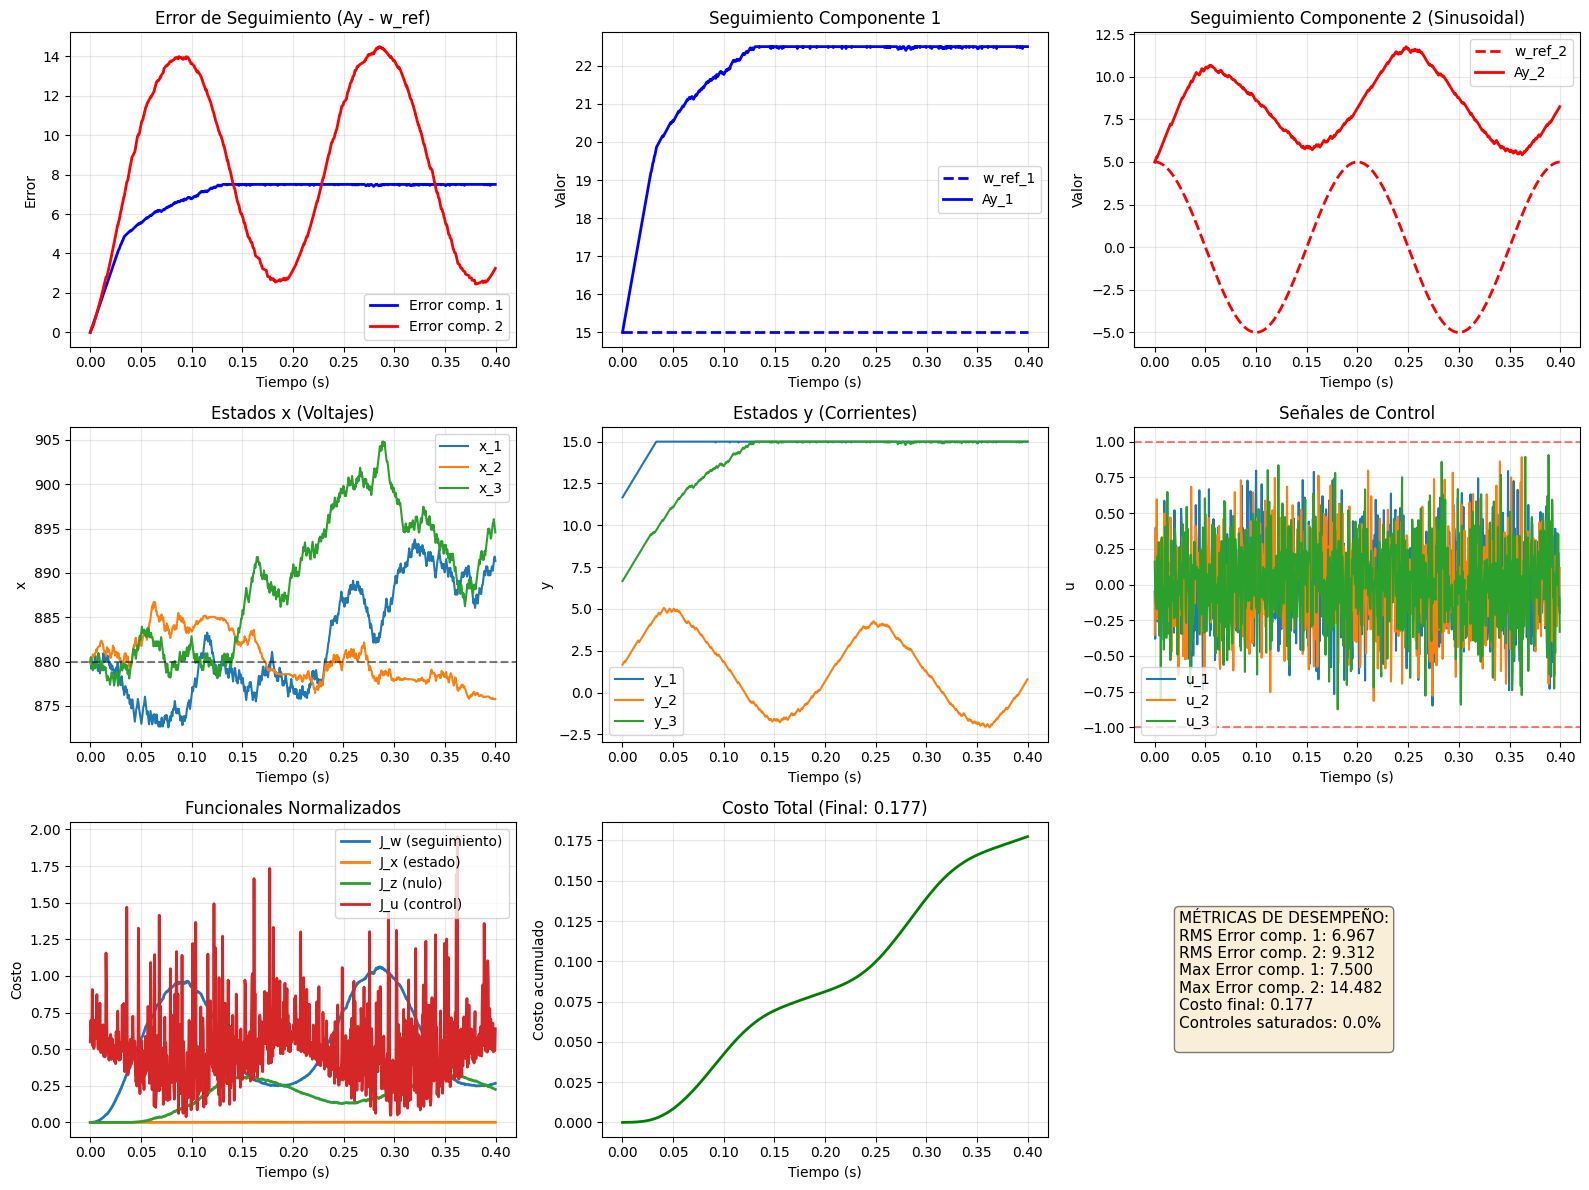

DIAGNÓSTICO DEL CONTROLADOR

1. ERROR INICIAL:
   w_ref(0) = [15.  5.]
   Ay(0) = [15.00000024  4.99999988]
   Error(0) = [ 2.38418579e-07 -1.19209290e-07]

2. CONVERGENCIA:
   Error RMS comp. 1: 6.9667
   Error RMS comp. 2: 9.3119

3. ANÁLISIS DE FRECUENCIA:
   Frecuencia de muestreo: 2000.0 Hz
   Frecuencia de referencia: 5.0 Hz
   Frecuencia dominante del error: 10.0 Hz

4. ANÁLISIS DE FASE:
   Retardo estimado: 45.5 ms
   Desfase: 81.9°



In [11]:
# REEMPLAZA TODO EL CÓDIGO DE ANÁLISIS CON ESTO:

import numpy as np
import matplotlib.pyplot as plt

# Parámetros consistentes con el entrenamiento
T = 0.4
N = ctrls.shape[0]
M = traj.shape[0]
dt = T / N
times = np.linspace(0, T, M)
times_ctrl = times[:-1]

# Extraer estados
x = traj[:, :3]
y = traj[:, 3:6]
z = traj[:, 6]
u = ctrls

# Matrices del sistema
A_mat = np.array([[1., 0., 0.5],
                  [0., 1., 0.5]])
A_pinv = np.linalg.pinv(A_mat)
K_mat = np.array([[ 2/3, -1/3, -1/3],
                  [-1/3,  2/3, -1/3],
                  [-1/3, -1/3,  2/3]])

# Referencias (CONSISTENTES CON EL ENTRENAMIENTO)
x_ref = np.array([880., 880., 880.])

# Parámetros de normalización
E_w_N_sq = 250.0  # Aproximado
E_x_N_sq = 500000.0
E_z_N_sq = 150.0
E_u_N_sq = 1000000.0

# Arrays para almacenar resultados
e_x_arr = np.zeros((N, 3))
e_w_arr = np.zeros((N, 2))
w_ref_arr = np.zeros((N, 2))
w_actual_arr = np.zeros((N, 2))
Jw = np.zeros(N)
Jx = np.zeros(N)
Jz = np.zeros(N)
Ju = np.zeros(N)

# Calcular errores para cada paso temporal
for i in range(N):
    t = times_ctrl[i]
    xi = x[i]
    yi = y[i]
    ui = u[i]

    # IMPORTANTE: Usar la MISMA frecuencia que en el entrenamiento (10π, no 40π)
    w_ref = np.array([15.0, 5.0 * np.cos(10.0 * np.pi * t)])  # ¡CORREGIDO!
    w_ref_arr[i] = w_ref

    # Salida actual
    w_actual = yi.dot(A_mat.T)
    w_actual_arr[i] = w_actual

    # Error de seguimiento
    ew = w_actual - w_ref
    e_w_arr[i] = ew

    # Error de estado
    ex = xi - x_ref
    e_x_arr[i] = ex

    # Error de espacio nulo
    zmat = np.eye(3) - A_pinv.dot(A_mat)
    ez = yi.dot(zmat.T)

    # Error de control
    d_ref = np.array([500.0, 300.0 * np.cos(10.0 * np.pi * t)])  # ¡CORREGIDO!
    ATd = d_ref.dot(A_mat)
    Kxu = (xi * ui).dot(K_mat.T)
    eu = ATd - Kxu

    # Funcionales normalizados
    Jw[i] = np.sum(ew**2) / E_w_N_sq
    Jx[i] = np.sum(ex**2) / E_x_N_sq
    Jz[i] = np.sum(ez**2) / E_z_N_sq
    Ju[i] = np.sum(eu**2) / E_u_N_sq

# ============================================================================
# VISUALIZACIÓN MEJORADA
# ============================================================================

# Crear figura con subplots organizados
fig = plt.figure(figsize=(16, 12))

# 1. Error de seguimiento Ay - w_ref
ax1 = plt.subplot(3, 3, 1)
ax1.plot(times_ctrl, e_w_arr[:,0], 'b-', label='Error comp. 1', linewidth=2)
ax1.plot(times_ctrl, e_w_arr[:,1], 'r-', label='Error comp. 2', linewidth=2)
ax1.set_xlabel('Tiempo (s)')
ax1.set_ylabel('Error')
ax1.set_title('Error de Seguimiento (Ay - w_ref)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Comparación w_ref vs Ay (componente 1)
ax2 = plt.subplot(3, 3, 2)
ax2.plot(times_ctrl, w_ref_arr[:,0], 'b--', label='w_ref_1', linewidth=2)
ax2.plot(times_ctrl, w_actual_arr[:,0], 'b-', label='Ay_1', linewidth=2)
ax2.set_xlabel('Tiempo (s)')
ax2.set_ylabel('Valor')
ax2.set_title('Seguimiento Componente 1')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Comparación w_ref vs Ay (componente 2)
ax3 = plt.subplot(3, 3, 3)
ax3.plot(times_ctrl, w_ref_arr[:,1], 'r--', label='w_ref_2', linewidth=2)
ax3.plot(times_ctrl, w_actual_arr[:,1], 'r-', label='Ay_2', linewidth=2)
ax3.set_xlabel('Tiempo (s)')
ax3.set_ylabel('Valor')
ax3.set_title('Seguimiento Componente 2 (Sinusoidal)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Estados x
ax4 = plt.subplot(3, 3, 4)
for i in range(3):
    ax4.plot(times, x[:,i], label=f'x_{i+1}')
ax4.axhline(y=880, color='k', linestyle='--', alpha=0.5)
ax4.set_xlabel('Tiempo (s)')
ax4.set_ylabel('x')
ax4.set_title('Estados x (Voltajes)')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Estados y
ax5 = plt.subplot(3, 3, 5)
for i in range(3):
    ax5.plot(times, y[:,i], label=f'y_{i+1}')
ax5.set_xlabel('Tiempo (s)')
ax5.set_ylabel('y')
ax5.set_title('Estados y (Corrientes)')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Controles
ax6 = plt.subplot(3, 3, 6)
for i in range(3):
    ax6.plot(times_ctrl, u[:,i], label=f'u_{i+1}')
ax6.axhline(y=1, color='r', linestyle='--', alpha=0.5)
ax6.axhline(y=-1, color='r', linestyle='--', alpha=0.5)
ax6.set_xlabel('Tiempo (s)')
ax6.set_ylabel('u')
ax6.set_title('Señales de Control')
ax6.legend()
ax6.grid(True, alpha=0.3)

# 7. Funcionales normalizados
ax7 = plt.subplot(3, 3, 7)
ax7.plot(times_ctrl, Jw, label='J_w (seguimiento)', linewidth=2)
ax7.plot(times_ctrl, Jx, label='J_x (estado)', linewidth=2)
ax7.plot(times_ctrl, Jz, label='J_z (nulo)', linewidth=2)
ax7.plot(times_ctrl, Ju, label='J_u (control)', linewidth=2)
ax7.set_xlabel('Tiempo (s)')
ax7.set_ylabel('Costo')
ax7.set_title('Funcionales Normalizados')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Costo acumulado
ax8 = plt.subplot(3, 3, 8)
ax8.plot(times, z, 'g-', linewidth=2)
ax8.set_xlabel('Tiempo (s)')
ax8.set_ylabel('Costo acumulado')
ax8.set_title(f'Costo Total (Final: {z[-1]:.3f})')
ax8.grid(True, alpha=0.3)

# 9. Métricas de error
ax9 = plt.subplot(3, 3, 9)
rms_w1 = np.sqrt(np.mean(e_w_arr[:,0]**2))
rms_w2 = np.sqrt(np.mean(e_w_arr[:,1]**2))
max_w1 = np.max(np.abs(e_w_arr[:,0]))
max_w2 = np.max(np.abs(e_w_arr[:,1]))

metrics_text = f"""MÉTRICAS DE DESEMPEÑO:
RMS Error comp. 1: {rms_w1:.3f}
RMS Error comp. 2: {rms_w2:.3f}
Max Error comp. 1: {max_w1:.3f}
Max Error comp. 2: {max_w2:.3f}
Costo final: {z[-1]:.3f}
Controles saturados: {100*np.mean(np.abs(u) > 0.95):.1f}%
"""
ax9.text(0.1, 0.5, metrics_text, transform=ax9.transAxes,
         fontsize=11, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax9.axis('off')

plt.tight_layout()
plt.show()

# ============================================================================
# ANÁLISIS DE DIAGNÓSTICO
# ============================================================================

print("=" * 60)
print("DIAGNÓSTICO DEL CONTROLADOR")
print("=" * 60)

# Analizar error inicial
print(f"\n1. ERROR INICIAL:")
print(f"   w_ref(0) = {w_ref_arr[0]}")
print(f"   Ay(0) = {w_actual_arr[0]}")
print(f"   Error(0) = {e_w_arr[0]}")

# Analizar convergencia
print(f"\n2. CONVERGENCIA:")
print(f"   Error RMS comp. 1: {rms_w1:.4f}")
print(f"   Error RMS comp. 2: {rms_w2:.4f}")

# Analizar frecuencia
from scipy import signal
fs = 1.0 / dt
freqs, psd = signal.welch(e_w_arr[:,1], fs=fs, nperseg=min(256, N//4))
peak_freq = freqs[np.argmax(psd)]
print(f"\n3. ANÁLISIS DE FRECUENCIA:")
print(f"   Frecuencia de muestreo: {fs:.1f} Hz")
print(f"   Frecuencia de referencia: 5.0 Hz")
print(f"   Frecuencia dominante del error: {peak_freq:.1f} Hz")

# Verificar si el problema es de fase o amplitud
if N > 100:
    # Tomar la parte estacionaria (últimos 50%)
    steady_idx = N // 2
    steady_w_ref = w_ref_arr[steady_idx:, 1]
    steady_w_actual = w_actual_arr[steady_idx:, 1]

    # Calcular correlación cruzada
    correlation = np.correlate(steady_w_actual - np.mean(steady_w_actual),
                              steady_w_ref - np.mean(steady_w_ref), 'same')
    lag = np.argmax(np.abs(correlation)) - len(correlation)//2
    phase_delay = lag * dt

    print(f"\n4. ANÁLISIS DE FASE:")
    print(f"   Retardo estimado: {phase_delay*1000:.1f} ms")
    print(f"   Desfase: {phase_delay * 5 * 360:.1f}°")

print("\n" + "=" * 60)